In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import os
import json

from utils import convert_to_dotdict

In [3]:
with open("hyperparams.json", "r") as f:
    hyperparams = convert_to_dotdict(json.load(f))

In [4]:
pth = "Data/NIFTY50"
all_nifty = list(os.walk(pth))

file_list = sorted(all_nifty[0][2])

In [5]:
import torch
from torch import nn
from torch.optim import Adadelta, Adam, SGD

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Dropping the stocks which start much later than 2000 and which end before most of the stocks**

While this will reduce the number of stocks to only 50% of the original amount, at least we will not lose out on length along the time axis, which is what would have happened if we had brought all the stocks' timelines to start at exactly the same date.

In [7]:
file_list_2000 = []

for i in range(len(file_list)-1):
    try:
        p = os.path.join(pth, file_list[i])
        df = pd.read_csv(p, parse_dates=['Date'])

        if df["Date"][0] == pd.to_datetime('2000-01-03', format='%Y-%m-%d') and len(df) == 5306:
            file_list_2000.append(file_list[i])
    except Exception as e:
        print(e)

0


In [8]:
# Checking if all the leftover stocks start at the same date in 2000 or not

first_date = pd.to_datetime('2000-01-03', format='%Y-%m-%d')

for i in range(len(file_list_2000)):

    print(f"Checking file {i}: {file_list_2000[i]}")
    current_file_path = os.path.join(pth, file_list_2000[i])
    current_file_df = pd.read_csv(current_file_path, parse_dates=['Date'])
    current_first_date = current_file_df["Date"].iloc[0]
    assert current_first_date == first_date, f"File {file_list_2000[i]} does not start on the same date as the first file."

Checking file 0: ASIANPAINT.csv
Checking file 1: AXISBANK.csv
Checking file 2: BPCL.csv
Checking file 3: CIPLA.csv
Checking file 4: DRREDDY.csv
Checking file 5: GRASIM.csv
Checking file 6: HDFC.csv
Checking file 7: HDFCBANK.csv
Checking file 8: HEROMOTOCO.csv
Checking file 9: HINDALCO.csv
Checking file 10: HINDUNILVR.csv
Checking file 11: ICICIBANK.csv
Checking file 12: INFY.csv
Checking file 13: IOC.csv
Checking file 14: ITC.csv
Checking file 15: MM.csv
Checking file 16: ONGC.csv
Checking file 17: RELIANCE.csv
Checking file 18: SBIN.csv
Checking file 19: SUNPHARMA.csv
Checking file 20: TATAMOTORS.csv
Checking file 21: TATASTEEL.csv
Checking file 22: TITAN.csv
Checking file 23: WIPRO.csv
Checking file 24: ZEEL.csv


## **A preliminary visalization of all the stocks we have**

In [9]:
import random

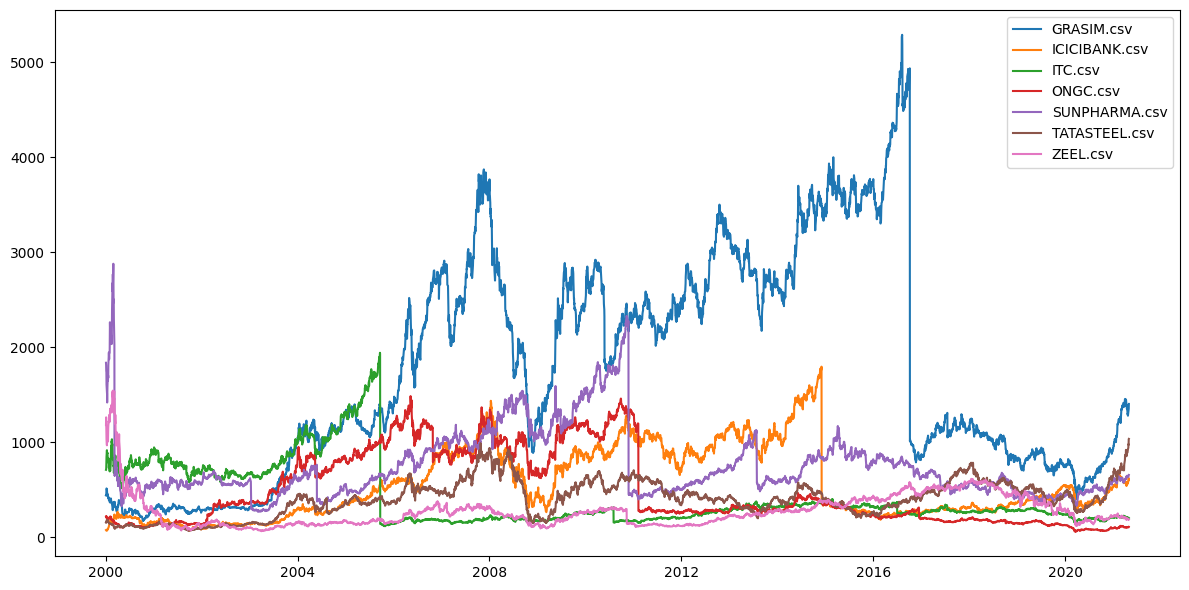

In [11]:
plt.figure(figsize=(12, 6))

for i in range(len(file_list_2000)):

    current_file_path = os.path.join(pth, file_list_2000[i])
    current_file_df = pd.read_csv(current_file_path, parse_dates=['Date'])
    current_close = current_file_df["Close"]
    current_close_index = current_file_df["Date"]

    # !randomly plot some lines and skip other lines for clarity
    z = random.choices([0, 1], weights=[6, 1])
    if z[0]:
         plt.plot(current_close_index, current_close, label=file_list_2000[i])


plt.legend()
plt.tight_layout()
plt.show()

The vertical straight lines are the decreased prices which occurred due to stock splits. For example, INFY stock (Infosys : file_list_2000[12]) split at:<br>
2018-09-12 

2015-06-25

2014-12-08

2006-07-18

2004-07-07

2000-02-15,

all of which correspond to vertical lines in its stock price graph.

## **Using log returns**

#### *Why log returns?*

$$\text{logReturn(finalValue, initialValue)} = \ln\left(\dfrac{\text{finalValue}}{\text{initialValue}}\right)$$


1.   log returns are additive, unlike percentage returns: $$\text{logReturn(finalValue, initialValue) = logReturn(finalValue, intermediateValue) + logReturn(intermediateValue, initialValue)}$$
2.   log returns represent the rate at which the initial value would turn into the final value in the given time, *if we assume* ***continuous compounding***.
3. Since stock prices tend to approximate a lognormal distribution, the log returns turn out to be normally distributed and the normality is preserved due to additivity (normal + normal $\implies$ normal)

In [68]:
dataframes = []

for i in range(len(file_list_2000)):
    p = os.path.join(pth, file_list_2000[i])
    df = pd.read_csv(p)

    df = df[["Date", "Close"]]
    df.loc[:, "logReturns"] = np.log(df["Close"]/df["Close"].shift(1))
    df.set_index(pd.to_datetime(df["Date"]), inplace=True)
    df.drop(columns=["Date", "Close"], inplace=True)
    df.dropna(inplace=True)

    dataframes.append(df)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

sns.kdeplot(dataframes[0]["logReturns"], ax=ax[0, 0], fill=True, color="r")
ax[0, 0].set_title("KDE Plot 1")

sns.kdeplot(dataframes[8]["logReturns"], ax=ax[0, 1], fill=True, color="g")
ax[0, 1].set_title("KDE Plot 2")

sns.kdeplot(dataframes[16]["logReturns"], ax=ax[1, 0], fill=True, color="b")
ax[1, 0].set_title("KDE Plot 3")

sns.kdeplot(dataframes[24]["logReturns"], ax=ax[1, 1], fill=True, color="m")
ax[1, 1].set_title("KDE Plot 4")

plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats as stats

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

fig.suptitle("Looks normal to me!")

stats.probplot(dataframes[0]["logReturns"], dist="norm", plot=ax[0,0])
stats.probplot(dataframes[8]["logReturns"], dist="norm", plot=ax[0, 1])
stats.probplot(dataframes[16]["logReturns"], dist="norm", plot=ax[1, 0])
stats.probplot(dataframes[24]["logReturns"], dist="norm", plot=ax[1, 1])

for i, j in [(x, y) for x in range(2) for y in range(2)]:
    ax[i, j].get_lines()[1].set_color('r')
    ax[i, j].get_lines()[1].set_linestyle('--')

    ax[i, j].get_lines()[0].set_color('k')
    ax[i, j].get_lines()[0].set_marker('x')
    ax[i, j].get_lines()[0].set_markersize(4)

    ax[i, j].set_title(f"Q-Q Plot {2**(i)*i + j + 1}")
    ax[i, j].set_xlabel('Theoretical Quantiles')
    ax[i, j].set_ylabel('Sample Quantiles')
    ax[i, j].set_xlim(-4, 4)
    ax[i, j].set_ylim(-0.3, 0.3)

plt.tight_layout()
plt.show()

In [ ]:
i = np.random.randint(len(dataframes))
plt.plot(dataframes[i]["logReturns"])
plt.title(f"{file_list_2000[i]} log Returns")
plt.figtext(0.5, -0.05, "The log returns look pretty much stationary except for sudden areas of large variability which correspond to the stock splits",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()

## **But wait, are these actually amenable for factor analysis? And if so, then what is the appropriate number of factors?**

***For this, we use the Kaiser-Meyer-Olkin (KMO) test*** : This statistic is a measure of the proportion of variance among variables that might be common variance. The higher the proportion, the higher the KMO-value, the more suited the data is to factor analysis. **Why**? Because the larger the common variance, the larger is the probability that the time behaviours of the cross-sectional data can be explained by the same factors, for every stock.

$$KMO = \frac{\sum \sum r_{ij}^2}{\sum \sum r_{ij}^2 + \sum \sum q_{ij}^2}$$

KMO value should be around 0.65 or above to be appropriate for factor analysis.


In [ ]:
allLogReturns = pd.DataFrame()

for i in range(len(dataframes)):
    allLogReturns = pd.concat([allLogReturns, dataframes[i]["logReturns"]], axis=1)

allLogReturns.columns = [f'logReturns{i}' for i in range(1, 26)]

corr_mat = allLogReturns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, annot=True,
            annot_kws={"fontsize":6,
                       "fontweight":"extra bold"})
plt.title("Correlation Matrix")
plt.show()

In [ ]:
%pip install -q factor-analyzer shutup

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shutup
shutup.please()

from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(allLogReturns.values)

print(f"KMO Value: {kmo_model}")

KMO Value: 0.8113019150343886


So this is an decent example of a dataset that is amenable to factor modelling. But what about the number of factors?


1.   **Kaiser-Guttman criterion** : The number of factors to include is equal to the number of eigenvalues of the correlation matrix.
2. **Catell's Scree** : Find the elbow in the scree plot.



Number of factors according to the Kaiser Guttmann criterion: 6





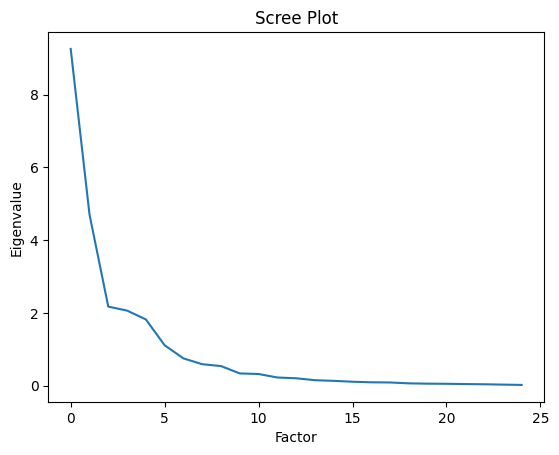

In [ ]:
# Kaiser-Guttman criterion

eigenvalues_, eigenvectors = np.linalg.eig(corr_mat)
eigenvalues = sorted(eigenvalues_, reverse=True)
eigenvalues = list(filter(lambda x: x > 0.97, eigenvalues))

print(f"Number of factors according to the Kaiser Guttmann criterion: {len(eigenvalues)}\n\n\n")

plt.plot(range(len(eigenvalues_)), sorted(eigenvalues_, reverse=True))
plt.title("Scree Plot")
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.show()

## **An alternative: trying simply returns**

In [ ]:
dataframes = []

for i in range(len(file_list_2000)):
    p = os.path.join(pth, file_list_2000[i])
    df = pd.read_csv(p)

    df = df[["Date", "Close"]]
    df.set_index(pd.to_datetime(df["Date"]), inplace=True)
    df.drop(columns=["Date"], inplace=True)
    df.dropna(inplace=True)

    dataframes.append(df)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

sns.kdeplot(dataframes[0]["Close"], ax=ax[0, 0], fill=True, color="r")
ax[0, 0].set_title("KDE Plot 1")

sns.kdeplot(dataframes[8]["Close"], ax=ax[0, 1], fill=True, color="g")
ax[0, 1].set_title("KDE Plot 2")

sns.kdeplot(dataframes[16]["Close"], ax=ax[1, 0], fill=True, color="b")
ax[1, 0].set_title("KDE Plot 3")

sns.kdeplot(dataframes[24]["Close"], ax=ax[1, 1], fill=True, color="m")
ax[1, 1].set_title("KDE Plot 4")

plt.tight_layout()
plt.show()

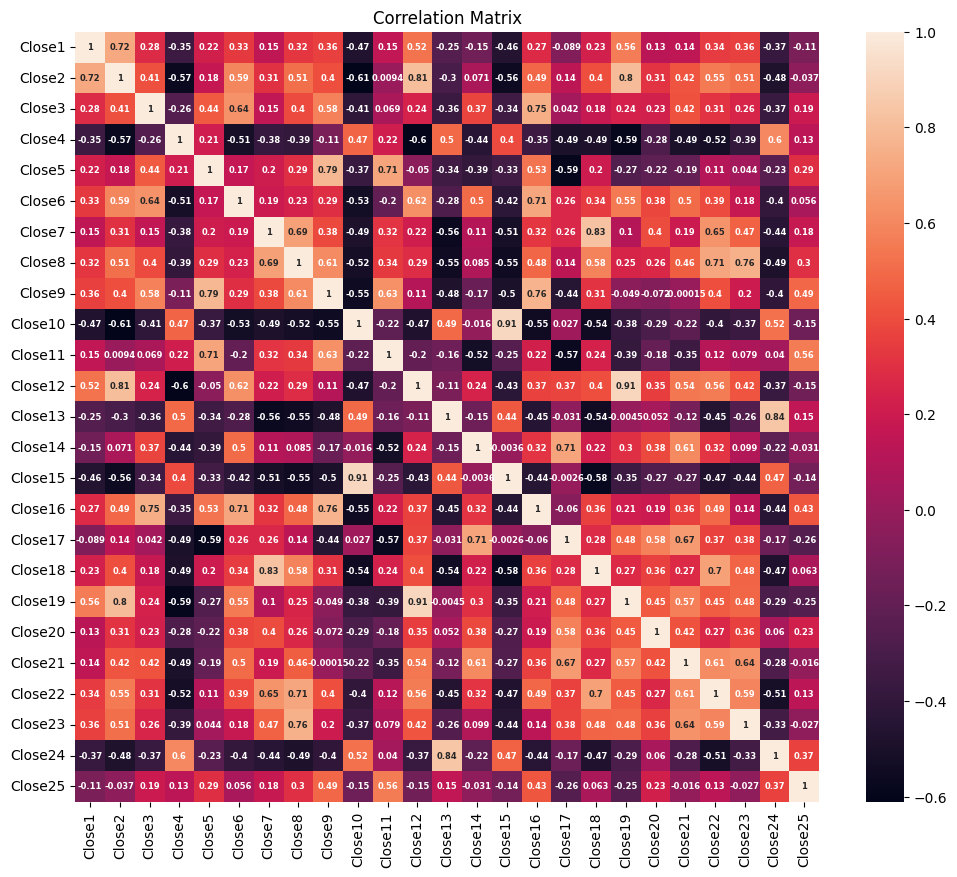

In [17]:
allReturns = pd.DataFrame()

for i in range(len(dataframes)):
    allReturns = pd.concat([allReturns, dataframes[i]["Close"]], axis=1)

allReturns.columns = [f'Close{i}' for i in range(1, 26)]

corr_mat = allReturns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, annot=True,
            annot_kws={"fontsize":6,
                       "fontweight":"extra bold"})
plt.title("Correlation Matrix")
plt.show()

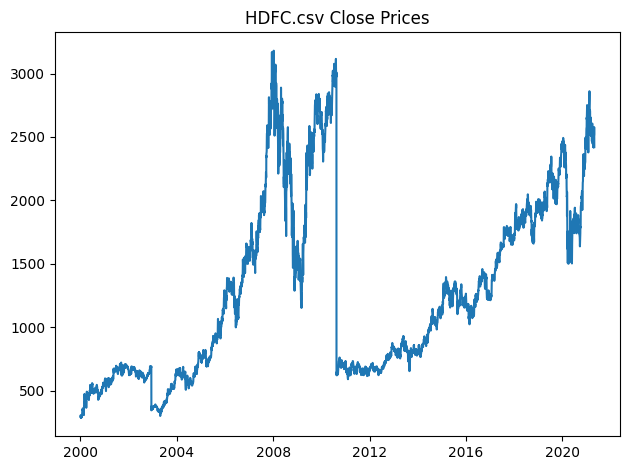

In [ ]:
i = np.random.randint(len(dataframes))
plt.plot(dataframes[i]["Close"])
plt.title(f"{file_list_2000[i]} Close Prices")
# plt.figtext(0.5, -0.05, "The log returns look pretty much stationary except for sudden areas of large variability which correspond to the stock splits",
            # wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()

In [18]:
%pip install -q factor-analyzer shutup

Note: you may need to restart the kernel to use updated packages.


In [19]:
import shutup
shutup.please()

from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(allReturns.values)

print(f"KMO Value: {kmo_model}")

KMO Value: 0.8113019150343886


So this is an decent example of a dataset that is amenable to factor modelling. But what about the number of factors?


1.   **Kaiser-Guttman criterion** : The number of factors to include is equal to the number of eigenvalues of the correlation matrix.
2. **Catell's Scree** : Find the elbow in the scree plot.



Number of factors according to the Kaiser Guttmann criterion: 6





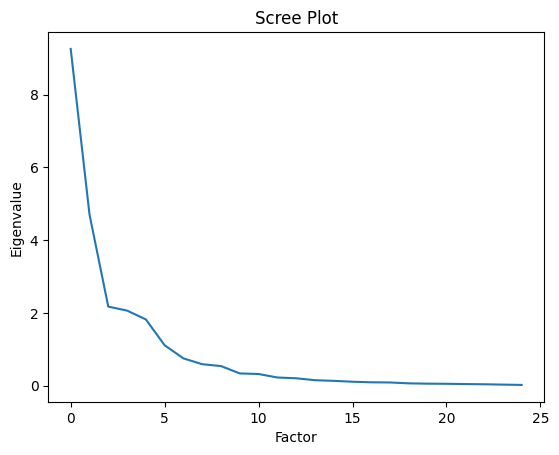

In [20]:
# Kaiser-Guttman criterion

eigenvalues_, eigenvectors = np.linalg.eig(corr_mat)
eigenvalues = sorted(eigenvalues_, reverse=True)
eigenvalues = list(filter(lambda x: x > 0.97, eigenvalues))

print(f"Number of factors according to the Kaiser Guttmann criterion: {len(eigenvalues)}\n\n\n")

plt.plot(range(len(eigenvalues_)), sorted(eigenvalues_, reverse=True))
plt.title("Scree Plot")
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.show()

## **Preparing the data and introducing lags of a given window size**

Here's what we want our data to look like:



![](logo.png)




In [ ]:
def introduce_lags(df, window_size):
    new = df
    for i in range(1, window_size+1):
        new[f"lag_{i}"] = df["logReturns"].shift(i)

    new.dropna(inplace=True)
    return new

for df in dataframes:
    df = introduce_lags(df, hyperparams.DATA.WINDOW_SIZE)

In [22]:
def introduce_lags_close(df, window_size):
    new = df
    for i in range(1, window_size+1):
        new[f"lag_{i}"] = df["Close"].shift(i)

    new.dropna(inplace=True)
    return new

for df in dataframes:
    df = introduce_lags_close(df, hyperparams.DATA.WINDOW_SIZE)

## **Creating a train_test split and loading data to the PyTorch DataLoader**

In [23]:
dataframes[0].head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-15,416.65,431.75,443.35,440.90,457.15,459.85,453.65,456.70,456.10,460.10,...,410.00,418.70,417.65,415.20,415.00,385.70,377.50,383.0,385.55,381.65
2000-02-16,399.10,416.65,431.75,443.35,440.90,457.15,459.85,453.65,456.70,456.10,...,411.35,410.00,418.70,417.65,415.20,415.00,385.70,377.5,383.00,385.55
2000-02-17,392.60,399.10,416.65,431.75,443.35,440.90,457.15,459.85,453.65,456.70,...,414.05,411.35,410.00,418.70,417.65,415.20,415.00,385.7,377.50,383.00
2000-02-18,402.45,392.60,399.10,416.65,431.75,443.35,440.90,457.15,459.85,453.65,...,419.35,414.05,411.35,410.00,418.70,417.65,415.20,415.0,385.70,377.50
2000-02-21,402.75,402.45,392.60,399.10,416.65,431.75,443.35,440.90,457.15,459.85,...,420.55,419.35,414.05,411.35,410.00,418.70,417.65,415.2,415.00,385.70


In [24]:
tens = []

for df in dataframes:
    tens.append(df.to_numpy())

tens = np.array(tens)
'''UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow.
    Please consider converting the list to a single numpy.ndarray with numpy.array()
    before converting to a tensor.'''

tens = torch.tensor(tens)
tens = tens.reshape([-1, tens.shape[2], tens.shape[0]])
tens.shape

torch.Size([5276, 31, 25])

In [25]:
X_train = tens[:int(hyperparams.DATA.TRAIN_SIZE * tens.shape[0]), 1: , :]
X_test = tens[int(hyperparams.DATA.TRAIN_SIZE * tens.shape[0]):, 1: , :]
y_train = tens[:int(hyperparams.DATA.TRAIN_SIZE * tens.shape[0]), 0 , :]
y_test = tens[int(hyperparams.DATA.TRAIN_SIZE * tens.shape[0]):, 0 , :]

In [26]:
assert X_train.shape[0] > 0
assert X_test.shape[0] > 0
assert y_train.shape[0] > 0
assert y_test.shape[0] > 0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4220, 30, 25]),
 torch.Size([1056, 30, 25]),
 torch.Size([4220, 25]),
 torch.Size([1056, 25]))

In [27]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.TRAINING.BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.TRAINING.BATCH_SIZE, shuffle=True)

## **Creating the Encoder and Decoder to build the final Variational Recurrent AutoEncoder**

This is the "Factor Network" mentioned in the paper.

In [28]:
class Encoder(nn.Module):

    def __init__(self, params):
        super(Encoder, self).__init__()

        self.params = params

        self.batch_size = self.params.batch_size
        self.num_stocks = int(self.params.num_stocks)
        self.num_factors = self.params.num_factors
        self.num_layers = self.params.num_layers
        self.hidden_size = self.params.hidden_size
        self.num_lags = self.params.num_lags
        self.dropout = self.params.dropout

        self.rnn = nn.LSTM(
            input_size=self.num_stocks,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True
        )
        print("Hi")
        self.relu = nn.ReLU()
        self.mu = nn.Linear(self.hidden_size, self.num_factors)
        self.log_sigma = nn.Linear(self.hidden_size, self.num_factors)

    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.relu(out)

        mu = self.mu(out)

        log_sigma = self.log_sigma(out)

        return mu, log_sigma

In [29]:
class Decoder(nn.Module):

    def __init__(self, params):
        super(Decoder, self).__init__()

        self.params = params

        self.batch_size = self.params.batch_size
        self.num_stocks = self.params.num_stocks
        self.num_factors = self.params.num_factors
        self.num_layers = self.params.num_layers
        self.hidden_size = self.params.hidden_size
        self.num_lags = self.params.num_lags
        self.dropout = self.params.dropout

        self.tanh_h0 = nn.Tanh()
        self.rnn = nn.LSTM(
                           input_size = self.num_factors,
                           hidden_size = self.hidden_size,
                           num_layers = self.num_layers,
                           dropout = self.dropout,
                           batch_first = True
                        )
        self.relu = nn.ReLU()
        self.fc = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, self.hidden_size)



    def forward(self, z):
        # z = self.tanh_h0(z)

        out, _ = self.rnn(z)
        out = out[:, -1, :]
        out = self.relu(out)
        # out = self.fc(out)
        # out = self.fc2(out)
        return out

In [30]:
class RVAE(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super(RVAE, self).__init__()
        self.encoder = Encoder(encoder_params)
        self.decoder = Decoder(decoder_params)

        self.weight_matrix = nn.Parameter(torch.randn(hyperparams.FACTOR_NETWORK.NUM_FACTORS,
                                                      hyperparams.DATA.NUM_STOCKS
                                                      ),
                                          requires_grad=True)
        
        self.num_factors = decoder_params.num_factors
        self.hidden_size = decoder_params.num_stocks

        self.fc1 = nn.Linear(hyperparams.DATA.NUM_STOCKS, hyperparams.FACTOR_NETWORK.NUM_FACTORS)
        self.mu = None
        self.logvar = None

        self.sigmoid = nn.Sigmoid()

    def sample(self, mu : list, logvar : list):
        assert len(mu) == len(logvar)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        self.mu = mu.to(dtype=torch.float32)
        self.logvar = logvar.to(dtype=torch.float32)
        z = self.sample(mu, logvar)
        out = self.decoder(z)

        out = self.fc1(out)
        # out = self.sigmoid(out)
        
        return torch.matmul(out, self.weight_matrix)

## **Creating the loss function and the training loop**

The loss function is a linear combination of the reconstruction/data-fidelity loss, and the KL divergence-loss between the empirical distribution $q_\theta(z|x)$ we approximated, versus the assumed prior $p(z) \sim \mathcal N(0, 1)$. The loss can be expressed as: $$D_{DF} + D_{KL} = KL[q_\theta(z|x)∥p(z)] - \mathbb E_Q[\log(p_\phi(x|z))]$$ <br>$$=\sum_{i=1}^k \bigg[ \|x_i - x_{pred}\|_2^2 + \frac12\cdot \bigg(\operatorname{tr}(\Sigma(x_i)) + \mu(x_i)^\top\mu(x_i) - k - \log\det(\Sigma(x_i))\bigg)\bigg]$$

where $k$ is the hidden dimension.

The expression, if we consider $(\Sigma(x_i))=\operatorname{diag}(\sigma^2)$, becomes 

$$\displaystyle{\sum_{i=1}^k \|x_i - x_{pred}\|_2^2 + \frac{k}{2} \sum_{i=1}^k \left( \sigma_i^2 + \mu_i^2 - 1 - \log(\sigma_i^2) \right).}
$$

A hyperparameter $\lambda$ can optionally be added as a weighting factor for the KL-divergence as compared to the reconstruction loss.

In [31]:
def loss_fn(x_pred : torch.Tensor,
            x_true : torch.Tensor,
            mu : torch.Tensor,
            logvar : torch.Tensor):

    assert x_pred.shape == x_true.shape, print(x_pred.shape, x_true.shape)
#     print(f"sd = {torch.mean(torch.sqrt(logvar.exp()))}    mu = {torch.mean(mu)}")

    assert mu.shape == logvar.shape

    reconstruction_loss = torch.sum((x_pred - x_true)**2)

    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)

    lambd = hyperparams.TRAINING.KL_LOSS_WEIGHT

    return reconstruction_loss + lambd * KLD

In [32]:
train_history = []
test_history = []

In [33]:
def train_one_epoch(epoch_index, model, optimizer):
    print("------------EPOCH", epoch_index, "----------------")

    running_loss = 0.0
    model.train(mode=True)

    for i, data in enumerate(train_dataloader):
        inputs, label = data
        optimizer.zero_grad()

        inputs = inputs.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)

        outputs = model(inputs)
        loss = loss_fn(outputs, label, model.mu, model.logvar)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    train_history.append(epoch_loss)
    return epoch_loss

In [34]:
encoder_params = convert_to_dotdict({
        "batch_size": hyperparams.TRAINING.BATCH_SIZE,
        "num_stocks": hyperparams.DATA.NUM_STOCKS,
        "num_lags": hyperparams.DATA.WINDOW_SIZE,
        "num_factors": hyperparams.FACTOR_NETWORK.NUM_FACTORS,
        "hidden_size": hyperparams.FACTOR_NETWORK.ENCODER.PARAMS.HIDDEN_SIZE,
        "dropout": hyperparams.FACTOR_NETWORK.ENCODER.PARAMS.DROPOUT_PROB,
        "num_layers": hyperparams.FACTOR_NETWORK.ENCODER.PARAMS.NUM_LAYERS
})

decoder_params = convert_to_dotdict({
        "batch_size": hyperparams.TRAINING.BATCH_SIZE,
        "num_stocks": hyperparams.DATA.NUM_STOCKS,
        "num_lags": hyperparams.DATA.WINDOW_SIZE,
        "num_factors": hyperparams.FACTOR_NETWORK.NUM_FACTORS,
        "hidden_size": hyperparams.FACTOR_NETWORK.DECODER.PARAMS.HIDDEN_SIZE,
        "dropout": hyperparams.FACTOR_NETWORK.DECODER.PARAMS.DROPOUT_PROB,
        "num_layers": hyperparams.FACTOR_NETWORK.DECODER.PARAMS.NUM_LAYERS
})

In [35]:
model = RVAE(encoder_params, decoder_params)
model.to(device)
optimizer = Adam(lr = hyperparams.TRAINING.LEARNING_RATE,
                 betas = (0.9, 0.9),
                 params=model.parameters())

Hi


In [36]:
for epoch in range(hyperparams.TRAINING.NUM_EPOCHS):
    model.train(mode=True)
    avg_loss = train_one_epoch(epoch, model, optimizer)

    running_test_loss = 0

    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(test_dataloader):
            test_inputs, test_label = data
            test_inputs, test_label = test_inputs.to(dtype=torch.float32), test_label.to(dtype=torch.float32)
            test_outputs = model(test_inputs)

            test_loss = loss_fn(test_outputs, test_label, model.mu, model.logvar)
            running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_dataloader)
    print(f"Epoch {epoch} Train loss: {avg_loss}, Test loss: {avg_test_loss}")

    test_history.append(avg_test_loss)

------------EPOCH 0 ----------------
Epoch 0 Train loss: 2861154897.4545455, Test loss: 826137589.6470588
------------EPOCH 1 ----------------
Epoch 1 Train loss: 2639758721.939394, Test loss: 681085489.882353
------------EPOCH 2 ----------------
Epoch 2 Train loss: 2258577085.090909, Test loss: 534077314.8235294
------------EPOCH 3 ----------------
Epoch 3 Train loss: 1833990533.8181818, Test loss: 519058125.1764706
------------EPOCH 4 ----------------
Epoch 4 Train loss: 1532683233.939394, Test loss: 730173679.0588236
------------EPOCH 5 ----------------
Epoch 5 Train loss: 1450323599.030303, Test loss: 796138089.4117647
------------EPOCH 6 ----------------
Epoch 6 Train loss: 1441314233.6969697, Test loss: 776169129.4117647
------------EPOCH 7 ----------------
Epoch 7 Train loss: 1441412320.0, Test loss: 798398880.0
------------EPOCH 8 ----------------
Epoch 8 Train loss: 1440358632.7272727, Test loss: 780555734.5882353
------------EPOCH 9 ----------------
Epoch 9 Train loss: 144141

KeyboardInterrupt: 

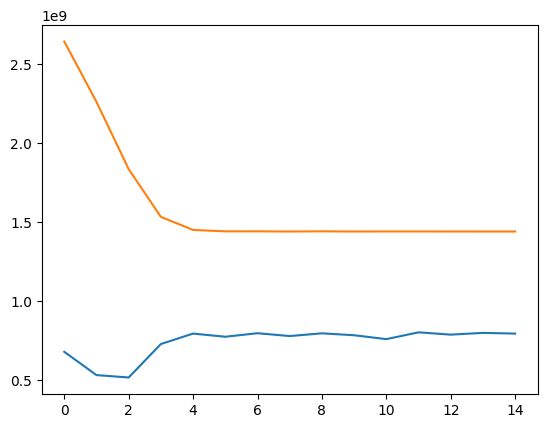

In [37]:
plt.plot(test_history[1:])
plt.plot(train_history[1:])
plt.show()

In [100]:
k = torch.tensor(np.array([dataframes[i].iloc[70, 1:] for i in range(25)]).reshape(1, 10, 25)).to(dtype=torch.float32)

ValueError: cannot reshape array of size 0 into shape (1,10,25)

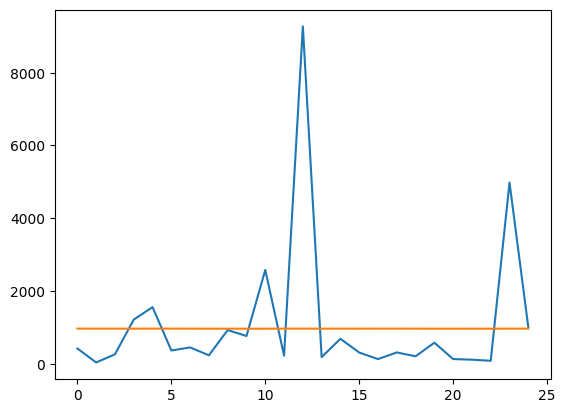

In [91]:
plt.plot([dataframes[i].iloc[70, 0] for i in range(25)])
plt.plot(model(k)[0].detach().numpy())
plt.show()

In [38]:
tru = []
pred = []
with torch.inference_mode():
        for i, data in enumerate(test_dataloader):
            test_inputs, test_label = data
            test_inputs, test_label = test_inputs.to(dtype=torch.float32), test_label.to(dtype=torch.float32)
            test_outputs = model(test_inputs)
            tru.append(test_label)
            pred.append(test_outputs)

pred[15][0], tru[15][0]

(tensor([970.0291, 970.1860, 970.9017, 969.8271, 969.0529, 968.7206, 969.5941,
         969.2713, 969.1078, 969.1698, 969.2930, 968.5158, 968.0496, 968.5522,
         970.7101, 970.2637, 969.7493, 969.2143, 969.6573, 969.4054, 968.1029,
         967.6316, 967.8385, 967.8846, 968.4797]),
 tensor([248.6500, 258.6500, 262.3500, 261.6500, 267.2000, 256.2000, 255.1500,
         250.8000, 244.1500, 241.8500, 239.8000, 238.8000, 241.0500, 242.4000,
         241.5000, 234.0500, 237.0000, 237.8000, 238.9000, 239.9500, 241.0000,
         239.0000, 240.5000, 239.5000, 234.9500]))